# UMA GTFS EDA

## Import Libraries

In [1]:
# analysis
import numpy as np
import pandas as pd
import json
import geopandas as gpd
# import gtfs_functions
# import gtfs_kit

# other
import warnings
import os
import requests

# visualisation libraries
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns

# Notebook styling
%matplotlib inline
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
warnings.filterwarnings("ignore")


# Import Datasets

In [2]:
root_gtfs_dir = os.path.join('..', '..', '..', 'resources', 'data',
                             'external', 'GTFS', 'latam_gtfs_v002')

cities = ['bogota', 'buenos_aires', 'mexico_city',
          'porto_alegre', 'santiago_deChile', 'sao_paulo']

files_required = ['agency.txt', 'stops.txt', 'routes.txt', 'shapes.txt']

In [3]:
from re import sub

gtfs_data = {}

for place in cities:
    
    print(place)
    gtfs_dir = os.path.join(root_gtfs_dir, place, 'GTFS')
    
    gtfs_data[place] = {sub('.txt', "", file):
                        pd.read_csv(os.path.join(gtfs_dir, file))
                        for basepath in os.listdir(gtfs_dir)
                        for file in files_required}
    

bogota
buenos_aires
mexico_city
porto_alegre
santiago_deChile
sao_paulo


# Extract common data fields from each table

Create object for common columns. This will be the first version of standard columns to use.

Analyis is required to determine if more columns are required.

name: `standard_columns`

In [5]:

city = 'sao_paulo'

# create new standard object
gtfs_data['standard_columns'] = {}


# check common folders for each file type
for file in [file.replace('.txt','') for file in files_required]:
    print(file)
    print(gtfs_data[city].keys())
    print("=====")
    
#     # ensure that key is in 
#     if file in gtfs_data[city]:
        
#         print([gtfs_data[city][file].columns
#                for city in gtfs_data.keys()])
        
    file_cols_per_city = [list(gtfs_data[city][file].columns)
                          for city in cities]
    
    print(file_cols_per_city)
    print("=====")
#     print(table_cols)
#     print(set.intersection(*[set(list) for list in table_cols]))
    
    
    # create set of columns that are common to all files
    gtfs_data['standard_columns'][sub('.txt', "", file)] = list(set.intersection(*[set(list)
                                                                                   for list in file_cols_per_city]))
    
#     print(gtfs_data.keys())
    print(gtfs_data['standard_columns'])
    
    print("\n\n")

agency
dict_keys(['agency', 'stops', 'routes', 'shapes'])
=====
[['agency_id', 'agency_name', 'agency_url', 'agency_timezone', 'agency_lang', 'agency_phone', 'agency_fare_url'], ['agency_id', 'agency_name', 'agency_url', 'agency_timezone', 'agency_lang', 'agency_phone', 'agency_fare_url'], ['agency_id', 'agency_name', 'agency_url', 'agency_timezone', 'agency_lang', 'agency_phone'], ['agency_id', 'agency_name', 'agency_url', 'agency_timezone', 'agency_lang', 'agency_phone', 'agency_fare_url'], ['agency_id', 'agency_name', 'agency_url', 'agency_timezone'], ['agency_id', 'agency_name', 'agency_url', 'agency_timezone', 'agency_lang']]
=====
{'agency': ['agency_timezone', 'agency_url', 'agency_name', 'agency_id']}



stops
dict_keys(['agency', 'stops', 'routes', 'shapes'])
=====
[['stop_id', 'stop_code', ' stop_name', 'stop_desc', 'stop_lat', 'stop_lon', 'stop_url', 'wheelchair_boarding'], ['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat', 'stop_lon', 'zone_id', 'stop_url', 'loc

In [6]:
for file in [file.replace('.txt','') for file in files_required]:
    
    print(file)
#     print(gtfs_data['standard_columns'])
    standard_columns = gtfs_data['standard_columns'][file]
    print(standard_columns)
#     print(gtfs_data[city]['standard_columns'])
#     print("\n\n")

agency
['agency_timezone', 'agency_url', 'agency_name', 'agency_id']
stops
['stop_lat', 'stop_lon', 'stop_id']
routes
['route_color', 'agency_id', 'route_text_color', 'route_long_name', 'route_type', 'route_short_name', 'route_id']
shapes
['shape_id', 'shape_pt_lat', 'shape_pt_sequence', 'shape_pt_lon']


# Coordinate Reference Systems (CRS) and Coordinate Projection Systems (CPS)


- [Brazil projections](https://epsg.io/?q=Brazil)
    - Sao Paulo EPSG: 31983
    - Porto Algere EPSG: 31982
- [Argentina projections](https://epsg.io/?q=Argentina)
    - Buenos Aires EPSG: 32721
- [South Africa projections](https://epsg.io/?q=south+africa)
    - Cape Town: 2048
    - Johannesburg: 2052
    - Durban: 2054
- [Chile projections](https://epsg.io/?q=chile)
    - Santiago de Chile EPSG: 9155
- [Mexico projections](https://epsg.io/?q=mexico)
    - Mexico City EPSG: 6369
- [Colombia projectins](https://epsg.io/?q=Colombia)
    - Bogota EPSG: 3116
    
```json
{"EPSG": {
	"sao_paulo": 31983
	"porto_algere": 31982
	"buenos_aires": 32721
	"cape_town": 2048
	"johannesburg": 2052
	"durban": 2054
	"santiago_deChile": 9155
	"mexico_city": 6369
	"bogota": 3116
    }
}
```



In [10]:
epsg_dict = {
    "sao_paulo": 31983,
    "porto_alegre": 31982,
    "buenos_aires": 32721,
    "cape_town": 2048,
    "johannesburg": 2052,
    "durban": 2054,
    "santiago_deChile": 9155,
    "mexico_city": 6369,
    "bogota": 3116,
    }



In [12]:
gtfs_data['epsg_code'] = {key:val for key, val in epsg_dict.items()
                          if key in cities}

print(gtfs_data['epsg_code'])

{'sao_paulo': 31983, 'porto_alegre': 31982, 'buenos_aires': 32721, 'santiago_deChile': 9155, 'mexico_city': 6369, 'bogota': 3116}


## Create Points

In [16]:
file = 'stops'
for city in cities:
    
    # 
    print(city)
    columns = gtfs_data['standard_columns'][file]
    temp_df = gtfs_data[city][file][columns]
    
    # create point features
    lon = temp_df['stop_lat']
    lat = temp_df['stop_lon']
    temp_gdf = gpd.GeoDataFrame(temp_df,
                                geometry=gpd.points_from_xy(lon, lat),
                                crs={'init' :'epsg:4326'})
    
    # reproject spatial data
    temp_gdf['city'] = city
    epsg_code = gtfs_data['epsg_code'][city]
    stops_newcrs = temp_gdf.to_crs(epsg=epsg_code)
    
    # create buffers around points
    stops_newcrs['buffer_100m'] = stops_newcrs.buffer(100)
    
    
    print(stops_newcrs.crs)
    print(stops_newcrs.info())
    print("\n\n")

bogota
epsg:3116
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12787 entries, 0 to 12786
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   stop_lat     12787 non-null  float64 
 1   stop_lon     12787 non-null  float64 
 2   stop_id      12787 non-null  int64   
 3   geometry     12787 non-null  geometry
 4   city         12787 non-null  object  
 5   buffer_100m  12787 non-null  geometry
dtypes: float64(2), geometry(2), int64(1), object(1)
memory usage: 599.5+ KB
None



buenos_aires
epsg:32721
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 42874 entries, 0 to 42873
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   stop_lat     42874 non-null  float64 
 1   stop_lon     42874 non-null  float64 
 2   stop_id      42874 non-null  int64   
 3   geometry     42874 non-null  geometry
 4   city         42874 non-null  object

## Create Routes

In [18]:
from shapely.geometry import LineString
file = 'shapes'
for city in cities:
    
    # 
    print(city)
    columns = gtfs_data['standard_columns'][file]
    temp_df = gtfs_data[city][file][columns]
    
    
    # create line features
    lon = temp_df['shape_pt_lat']
    lat = temp_df['shape_pt_lon']
    temp_gdf = gpd.GeoDataFrame(temp_df,
                                geometry=gpd.points_from_xy(lon, lat))
    temp_gdf = temp_gdf.groupby(['shape_id'])['geometry'].apply(lambda x: LineString(x.tolist()))
    temp_gdf = gpd.GeoDataFrame(line_gdf, geometry='geometry',
                                crs={'init' :'epsg:4326'})
    
    # reproject spatial data
    temp_gdf['city'] = city
    epsg_code = gtfs_data['epsg_code'][city]
    line_newcrs = temp_gdf.to_crs(epsg=epsg_code)
    
    
    # create buffers around lines
    line_newcrs['buffer_100m'] = line_newcrs['geometry'].buffer(100)
    
    
    
    print(line_newcrs.crs)
    print(line_newcrs.info())
    print("\n\n")

bogota
epsg:3116
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1823 entries, 17838 to 72474
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   geometry     1823 non-null   geometry
 1   city         1823 non-null   object  
 2   buffer_100m  1823 non-null   geometry
dtypes: geometry(2), object(1)
memory usage: 57.0+ KB
None



buenos_aires
epsg:32721
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1823 entries, 17838 to 72474
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   geometry     1823 non-null   geometry
 1   city         1823 non-null   object  
 2   buffer_100m  1823 non-null   geometry
dtypes: geometry(2), object(1)
memory usage: 57.0+ KB
None



mexico_city
epsg:6369
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1823 entries, 17838 to 72474
Data columns (total 3 columns):
 #   Column       Non-Null

# Consolidate Features

## Transit Stops

In [19]:
stops_newcrs.dissolve('city')

geometry   stop_lat  \
city                                                                      
sao_paulo  MULTIPOINT (2107273.915 4600386.061, 2109302.1... -23.554022   

            stop_lon  stop_id  \
city                            
sao_paulo -46.671108    18848   

                                                 buffer_100m  
city                                                          
sao_paulo  POLYGON ((2137480.566 4603277.916, 2137480.084...

<AxesSubplot:>

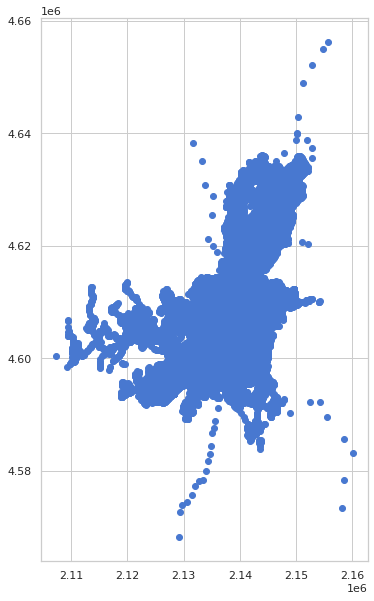

In [20]:
stops_newcrs.dissolve('city').plot()

## Transit Stops

In [21]:
line_newcrs.dissolve('city')

geometry  \
city                                                           
sao_paulo  MULTILINESTRING ((2131311.499 4608595.723, 213...   

                                                 buffer_100m  
city                                                          
sao_paulo  POLYGON ((2131382.453 4608666.423, 2131396.184...

<AxesSubplot:>

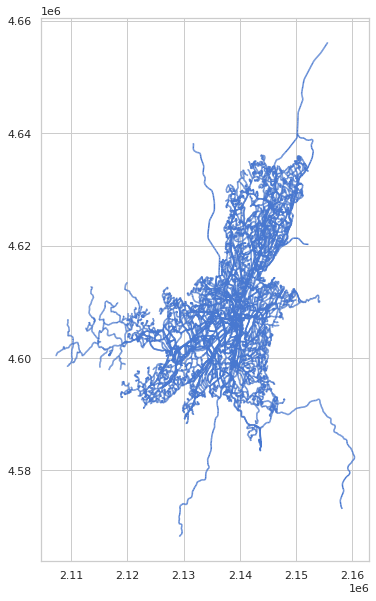

In [22]:
line_newcrs.dissolve('city').plot()